In [1]:
!pip install -U efficientnet opendatasets --quiet

     |████████████████████████████████| 50 kB 6.0 MB/s 


In [2]:
import opendatasets as od

url = "https://www.kaggle.com/competitions/kitchenware-classification/data"
od.download(url)

100%|██████████| 1.63G/1.63G [00:56<00:00, 31.2MB/s]



Extracting archive ./kitchenware-classification/kitchenware-classification.zip to ./kitchenware-classification


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Activation,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.models import Model
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
import efficientnet.keras as efn
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
def append_ext(fp):
  return fp + ".jpg"

In [6]:
train_df = pd.read_csv("./kitchenware-classification/train.csv", dtype=str)
test_df = pd.read_csv("./kitchenware-classification/test.csv", dtype=str)
submit_df = pd.read_csv("./kitchenware-classification/sample_submission.csv")

In [7]:
train_df["Id"] = train_df["Id"].apply(append_ext)
test_df["Id"] = test_df["Id"].apply(append_ext)

In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255., 
    validation_split=0.25,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Import data from dataframes and directories and turn it into batches
efn_train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

efn_valid_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./kitchenware-classification/images/",
    x_col="Id",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(224,224)
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.
Found 3808 validated image filenames.


In [9]:
base_model = efn.EfficientNetB7(
    input_shape = (224, 224, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model_10B = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_10B.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=["accuracy"]
)

# Fitting the model
STEP_SIZE_TRAIN = efn_train_generator.n // efn_train_generator.batch_size
STEP_SIZE_VALID = efn_valid_generator.n // efn_valid_generator.batch_size
STEP_SIZE_SET = test_generator.n // test_generator.batch_size 

history_10B = model_10B.fit(
    efn_train_generator,
    epochs=5,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=efn_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    verbose=1,
)

258434480/258434480 [==============================] - 39s 0us/step
Epoch 1/5
130/130 [==============================] - 165s 1s/step - loss: 2.6285 - accuracy: 0.7484 - val_loss: 0.4171 - val_accuracy: 0.8968
Epoch 2/5
130/130 [==============================] - 144s 1s/step - loss: 1.1873 - accuracy: 0.8241 - val_loss: 0.4108 - val_accuracy: 0.9026
Epoch 3/5
130/130 [==============================] - 149s 1s/step - loss: 0.8163 - accuracy: 0.8398 - val_loss: 0.2611 - val_accuracy: 0.9310
Epoch 4/5
130/130 [==============================] - 137s 1s/step - loss: 0.6124 - accuracy: 0.8567 - val_loss: 0.2918 - val_accuracy: 0.8961
Epoch 5/5
130/130 [==============================] - 132s 1s/step - loss: 0.5251 - accuracy: 0.8724 - val_loss: 0.2914 - val_accuracy: 0.9222


In [11]:
model_10B.save('./kirchenwareModel.h5')

In [12]:
final_model = load_model('./kirchenwareModel.h5',compile=False)

In [14]:
labels = (efn_train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in y_preds]
labels

{0: 'cup', 1: 'fork', 2: 'glass', 3: 'knife', 4: 'plate', 5: 'spoon'}

In [19]:
def output(img_location):
  img = tf.keras.utils.load_img(img_location,target_size=(224,224,3))
  img = tf.keras.utils.img_to_array(img)
  img = img / 255
  img = np.expand_dims(img,[0])

  y_softmax = final_model.predict(img, verbose=0)
  y_preds = np.argmax(y_softmax, axis=-1)

  y = " ".join(str(x) for x in y_preds)
  y = int(y)

  res = labels[y]

  return res

'plate'

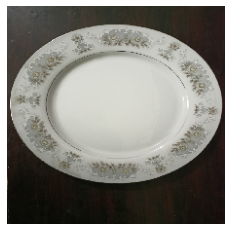

In [20]:
img_location = './kitchenware-classification/images/8265.jpg'
pic = tf.keras.utils.load_img(
    img_location, 
    target_size=(224,224,3), 
)
plt.imshow(pic)
plt.axis(False)
output(img_location)